# data import

In [3]:
import pandas as pd
# Set the display.max_rows option to None
pd.set_option('display.max_rows', None)
#supress warning
import warnings
warnings.filterwarnings("ignore")
# set the float_format option to display numbers with 4 decimal places
pd.options.display.float_format = "{:.4f}".format

In [4]:
# read excel file
file_path = 'OriginalDataPorject4.xlsx'
xls = pd.ExcelFile(file_path)

# loop over sheet names and read each sheet into a pandas dataframe
dfs = {}
for sheet_name in xls.sheet_names:
    dfs[sheet_name] = pd.read_excel(xls, sheet_name)

In [5]:
print(xls.sheet_names)

['transactions', 'products', 'seasonality', 'promo_ad', 'event_holiday']


In [6]:
# access individual dataframes using sheet names
transactionsDF = dfs['transactions']
productsDF= dfs['products']
seasonalityDF = dfs['seasonality']
promoDF= dfs['promo_ad']
holidayDF= dfs['event_holiday']

In [8]:
transactionsDF.head(1)

,cust_id,prod_id,trans_id,trans_dt,sales_qty,sales_amt
0,1126801552,23141593,190127010000109698,2019-01-27,1,9.9900


In [9]:
productsDF.head(1)

,prod_id,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,23141592,SAN MIGUEL ESPECIAL,Liquor,Beer,Import Beer,Super Premium,SNMG,1,ML,650


In [10]:
seasonalityDF.head(1)

,week,seas_index
0,2017-06-25,1.1004


In [11]:
promoDF.head(1)

,week,vehicle,amount,unit,prod_id,cost
0,2019-01-27,Display,1,NaN,ALL,4500.0000


In [12]:
holidayDF.head(1)

,week,event_holiday
0,2018-12-30,New Year


# convert all DataFrame to year_week basis

In [13]:
# extract the year_week from the date column
transactionsDF['year_week'] = transactionsDF['trans_dt'].dt.strftime('%Y-%U')
#transactionsDF.head(1)

In [14]:
seasonalityDF['year_week'] = seasonalityDF['week'].dt.strftime('%Y-%U')
#seasonalityDF.head(1)

In [15]:
promoDF['year_week'] = promoDF['week'].dt.strftime('%Y-%U')
#promoDF.head(1)

In [16]:
holidayDF['year_week'] = holidayDF['week'].dt.strftime('%Y-%U')
#holidayDF.head(1)

# aggegragte sales_qty & price in transactionsDF using year_week column

In [17]:
#create price column using sales_amt/sales_qty
transactionsDF['price'] = transactionsDF['sales_amt'] / transactionsDF['sales_qty']
transactionsDF.head(5)

,cust_id,prod_id,trans_id,trans_dt,sales_qty,sales_amt,year_week,price
0,1126801552,23141593,190127010000109698,2019-01-27,1,9.9900,2019-04,9.9900
1,1129263437,23141593,190127010000109643,2019-01-27,1,9.9900,2019-04,9.9900
2,1148577540,23141593,190127010000109827,2019-01-27,1,9.9900,2019-04,9.9900
3,1131341193,23141592,190127010000206031,2019-01-27,1,3.9900,2019-04,3.9900
4,1151750173,23141592,190127010000206174,2019-01-27,2,7.9800,2019-04,3.9900


In [18]:
# # write out to csv
# transactionsDF.to_csv('transactionsDF_year_week.csv', index=False)

In [19]:
#one problem is date in week 2020-00(such as 2020-01-01), which is actually in the week of 2019-52, so convert it back
# replace "2020-00" with "2019-52"
transactionsDF['year_week'] = transactionsDF['year_week'].replace('2020-00', '2019-52')

In [20]:
AggTransDF = (transactionsDF
              .groupby(['year_week', 'prod_id'])
              .agg({'sales_qty': 'sum', 'price': 'mean'})
              .reset_index())
AggTransDF.head(4)

,year_week,prod_id,sales_qty,price
0,2019-04,23141592,1886,3.9900
1,2019-04,23141593,2465,9.9900
2,2019-05,23141592,777,4.9900
3,2019-05,23141593,655,13.9900


In [21]:
AggTransDF.shape # no null value

(200, 4)

# combine seasonality and holiday to transaction df

In [23]:
#combine seasonality
AggTransDF = pd.merge(AggTransDF, seasonalityDF[['year_week', 'seas_index']], on='year_week', how='left')
# AggTransDF.head(5)

In [24]:
#pivot holiday table
pivoted_df = holidayDF.pivot(index='year_week', columns='event_holiday', values='event_holiday')
pivoted_df.columns.name = None
pivoted_df = pivoted_df.reset_index()
# print the pivoted dataframe
pivoted_df.head(2)

,year_week,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl
0,2018-52,NaN,NaN,NaN,NaN,NaN,NaN,New Year,NaN,NaN,NaN
1,2019-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pre Super Bowl,NaN


In [25]:
#convert all holiday to 1(numerical value), and fill null value to 0
import numpy as np
# replace non-null values with 1 and null values with 0
pivoted_df.iloc[:, 1:] = pivoted_df.iloc[:, 1:].applymap(lambda x: 1 if not pd.isnull(x) else 0)
pivoted_df.head(2)

,year_week,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl
0,2018-52,0,0,0,0,0,0,1,0,0,0
1,2019-04,0,0,0,0,0,0,0,0,1,0


In [26]:
#combine holiday -- pivot version
AggTransDF = pd.merge(AggTransDF, pivoted_df, on='year_week', how='left')
#fill NA with 0
AggTransDF.fillna(0, inplace=True)
AggTransDF.head(5)

,year_week,prod_id,sales_qty,price,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl
0,2019-04,23141592,1886,3.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
1,2019-04,23141593,2465,9.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,2019-05,23141592,777,4.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,2019-05,23141593,655,13.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,2019-06,23141592,576,4.9900,0.8830,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [29]:
# # write out to csv
# AggTransDF.to_csv('AggTransPivotDF.csv', index=False)

# split dataset by product

In [30]:
Trans92 = AggTransDF[AggTransDF['prod_id'] == 23141592]
Trans93 = AggTransDF[AggTransDF['prod_id'] == 23141593]
Trans92.head(3)
# Trans92.to_csv('Trans92.csv', index=False)
# Trans93.to_csv('Trans93.csv', index=False)

,year_week,prod_id,sales_qty,price,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,National Day,New Year,Pre Easter,Pre Super Bowl,Super Bowl
0,2019-04,23141592,1886,3.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,2019-05,23141592,777,4.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,2019-06,23141592,576,4.9900,0.8830,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Then Split Promo DF by prod_id. If promotion apply to 2 products, halve the cost.

In [32]:
# since object type includes both string and non-string values,convert all to string
promoDF['prod_id'] = promoDF['prod_id'].astype(str)

In [33]:
promo92 = promoDF[(promoDF["prod_id"] == "23141592") | (promoDF["prod_id"] == "ALL")]
promo93 = promoDF[(promoDF["prod_id"] == "23141593") | (promoDF["prod_id"] == "ALL")]
promo93.head(5)

,week,vehicle,amount,unit,prod_id,cost,year_week
0,2019-01-27,Display,1,NaN,ALL,4500.0000,2019-04
1,2019-03-03,Display,1,NaN,23141593,3000.0000,2019-09
2,2019-03-10,Display,1,NaN,23141593,3000.0000,2019-10
3,2019-03-31,Display,1,NaN,23141593,3000.0000,2019-13
4,2019-04-07,Display,1,NaN,23141593,3000.0000,2019-14


In [34]:
#adjust the cost
def adjust_cost(row):
    if row['prod_id'] == 'ALL':
        return row['cost'] / 2
    else:
        return row['cost']

promo92['cost'] = promo92.apply(adjust_cost, axis=1)    
promo93['cost'] = promo93.apply(adjust_cost, axis=1)
promo93.head(5)

,week,vehicle,amount,unit,prod_id,cost,year_week
0,2019-01-27,Display,1,NaN,ALL,2250.0000,2019-04
1,2019-03-03,Display,1,NaN,23141593,3000.0000,2019-09
2,2019-03-10,Display,1,NaN,23141593,3000.0000,2019-10
3,2019-03-31,Display,1,NaN,23141593,3000.0000,2019-13
4,2019-04-07,Display,1,NaN,23141593,3000.0000,2019-14


In [35]:
# promo92.to_csv('promo92.csv', index=False)
# promo93.to_csv('promo93.csv', index=False)

#  Pivot both Promo92 and Promo93 DFs 

In [36]:
promo92Pivot =promo92.pivot(index='year_week', columns='vehicle', values=['amount','cost'])
promo92Pivot.columns.name = None
promo92Pivot = promo92Pivot.reset_index()
promo92Pivot.fillna(0, inplace=True)
promo92Pivot.head(2)

year_week  amount                                                   \
vehicle           Display Facebook Banner  Flyer Google Paid Search  Radio   
0         2019-01  0.0000      24627.0000 0.0000          2357.0000 0.0000   
1         2019-02  0.0000      43313.0000 0.0000          8734.0000 0.0000   

                   cost                                                   \
vehicle      TV Display Facebook Banner  Flyer Google Paid Search  Radio   
0       30.0000  0.0000        490.3750 0.0000           222.5000 0.0000   
1       15.0000  0.0000        857.6250 0.0000           930.0000 0.0000   

                   
vehicle        TV  
0       8000.0000  
1       4000.0000

In [37]:
#reformat column names
promo92Pivot.columns = ['_'.join(map(str, col)).strip() for col in promo92Pivot.columns.values]
promo92Pivot = promo92Pivot.rename(columns={'amount_Display': 'Display_Amount', 
                                      'amount_Facebook Banner': 'Facebook_Banner_Amount',
                                      'amount_Flyer': 'Flyer_Amount',
                                      'amount_Google Paid Search': 'Google_Paid_Search_Amount',
                                      'amount_Radio': 'Radio_Amount',
                                      'amount_TV': 'TV_Amount',
                                      'cost_Display': 'Display_Cost', 
                                      'cost_Facebook Banner': 'Facebook_Banner_Cost',
                                      'cost_Flyer': 'Flyer_Cost',
                                      'cost_Google Paid Search': 'Google_Paid_Search_Cost',
                                      'cost_Radio': 'Radio_Cost',
                                      'cost_TV': 'TV_Cost'})
promo92Pivot.head(2)

,year_week_,Display_Amount,Facebook_Banner_Amount,Flyer_Amount,Google_Paid_Search_Amount,Radio_Amount,TV_Amount,Display_Cost,Facebook_Banner_Cost,Flyer_Cost,Google_Paid_Search_Cost,Radio_Cost,TV_Cost
0,2019-01,0.0000,24627.0000,0.0000,2357.0000,0.0000,30.0000,0.0000,490.3750,0.0000,222.5000,0.0000,8000.0000
1,2019-02,0.0000,43313.0000,0.0000,8734.0000,0.0000,15.0000,0.0000,857.6250,0.0000,930.0000,0.0000,4000.0000


In [38]:
#repeat the same process for promo93 DF
promo93Pivot =promo93.pivot(index='year_week', columns='vehicle', values=['amount','cost'])
promo93Pivot.columns.name = None
promo93Pivot = promo93Pivot.reset_index()
promo93Pivot.fillna(0, inplace=True)
promo93Pivot.head(2)
#reformat column names
promo93Pivot.columns = ['_'.join(map(str, col)).strip() for col in promo93Pivot.columns.values]
promo93Pivot = promo93Pivot.rename(columns={'amount_Display': 'Display_Amount', 
                                      'amount_Facebook Banner': 'Facebook_Banner_Amount',
                                      'amount_Flyer': 'Flyer_Amount',
                                      'amount_Google Paid Search': 'Google_Paid_Search_Amount',
                                      'amount_Radio': 'Radio_Amount',
                                      'amount_TV': 'TV_Amount',
                                      'cost_Display': 'Display_Cost', 
                                      'cost_Facebook Banner': 'Facebook_Banner_Cost',
                                      'cost_Flyer': 'Flyer_Cost',
                                      'cost_Google Paid Search': 'Google_Paid_Search_Cost',
                                      'cost_Radio': 'Radio_Cost',
                                      'cost_TV': 'TV_Cost'})
promo93Pivot.head(2)

,year_week_,Display_Amount,Facebook_Banner_Amount,Flyer_Amount,Google_Paid_Search_Amount,Radio_Amount,TV_Amount,Display_Cost,Facebook_Banner_Cost,Flyer_Cost,Google_Paid_Search_Cost,Radio_Cost,TV_Cost
0,2019-01,0.0000,24627.0000,0.0000,2357.0000,0.0000,30.0000,0.0000,490.3750,0.0000,222.5000,0.0000,8000.0000
1,2019-02,0.0000,43313.0000,0.0000,8734.0000,0.0000,15.0000,0.0000,857.6250,0.0000,930.0000,0.0000,4000.0000


In [39]:
promo92Pivot = promo92Pivot.rename(columns={'year_week_': 'year_week'})
promo93Pivot = promo93Pivot.rename(columns={'year_week_': 'year_week'})

In [40]:
# promo92Pivot.to_csv('promo92Pivot.csv', index=False)
# promo93Pivot.to_csv('promo93Pivot.csv', index=False)

# join promo92 & promo93 with trans92 & trans93

In [42]:
#join on year_week column
All92df = pd.merge(Trans92, promo92Pivot, on='year_week', how='left')
#fill NA with 0
All92df.fillna(0, inplace=True)
All92df.head(5)

,year_week,prod_id,sales_qty,price,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,...,Flyer_Amount,Google_Paid_Search_Amount,Radio_Amount,TV_Amount,Display_Cost,Facebook_Banner_Cost,Flyer_Cost,Google_Paid_Search_Cost,Radio_Cost,TV_Cost
0,2019-04,23141592,1886,3.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,8611.0000,10.0000,0.0000,2250.0000,1821.1250,1250.0000,1214.0000,1200.0000,0.0000
1,2019-05,23141592,777,4.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,8245.0000,5.0000,0.0000,0.0000,594.8750,0.0000,940.0000,600.0000,0.0000
2,2019-06,23141592,576,4.9900,0.8830,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,7246.0000,0.0000,0.0000,0.0000,628.7500,0.0000,837.0000,0.0000,0.0000
3,2019-07,23141592,530,4.9900,0.8866,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,3950.0000,0.0000,0.0000,0.0000,1891.2500,0.0000,444.5000,0.0000,0.0000
4,2019-08,23141592,477,4.9900,0.7818,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,6716.0000,0.0000,0.0000,0.0000,1571.8750,0.0000,977.0000,0.0000,0.0000


In [43]:
#join on year_week column
All93df = pd.merge(Trans93, promo93Pivot, on='year_week', how='left')
All93df.fillna(0, inplace=True)

In [45]:
# All93df.to_csv('All93df.csv', index=False)

# GRP > AdStock GRP

In [46]:
h_tv = 6
h_radio = 3
alpha_tv = 1- pow(0.5, (1/h_tv)) # 0.109
alpha_radio = 1- pow(0.5, (1/h_radio)) # 0.206

In [47]:
ReachDF=All92df
#calculate row 1 for adstock_tv & adstock_radio
#initilize new column
ReachDF['temp_radio'] = 0
ReachDF['temp_tv'] = 0
#initilize value in first row for both new column
ReachDF.at[0, 'temp_radio'] = ReachDF.at[0, 'Radio_Amount'] * alpha_radio 
ReachDF.at[0, 'temp_tv'] = ReachDF.at[0, 'TV_Amount'] * alpha_tv

In [48]:
ReachDF[['Radio_Amount', 'temp_radio','TV_Amount','temp_tv']].head(20)

,Radio_Amount,temp_radio,TV_Amount,temp_tv
0,10.0000,2.0630,0.0000,0
1,5.0000,0.0000,0.0000,0
2,0.0000,0.0000,0.0000,0
3,0.0000,0.0000,0.0000,0
4,0.0000,0.0000,0.0000,0
5,0.0000,0.0000,0.0000,0
6,0.0000,0.0000,0.0000,0
7,0.0000,0.0000,0.0000,0
8,0.0000,0.0000,0.0000,0
9,0.0000,0.0000,20.0000,0


In [49]:
#compute alpha*GRP at week T 
ReachDF['temp_radio'].iloc[1:] = ReachDF['Radio_Amount'].iloc[1:]* alpha_radio
ReachDF['temp_tv'].iloc[1:] = ReachDF['TV_Amount'].iloc[1:]* alpha_tv

In [50]:
#initilize new column
ReachDF['ads_radio'] = 0
ReachDF['ads_tv'] = 0
#initilize value in first row for both new column
ReachDF.at[0, 'ads_radio'] = ReachDF.at[0, 'temp_radio']
ReachDF.at[0, 'ads_tv'] = ReachDF.at[0, 'temp_tv']

In [51]:
#add (1-alpha)*Adstock at week T-1. 
# Radio:（1-alpha_radio= 0.794）
# TV: (1-alpha_TV= 0.891）
for i in range(1, len(ReachDF)):
    #Radio
    ReachDF.loc[i, 'ads_radio'] = (1-alpha_radio) * ReachDF.loc[i-1, 'ads_radio']
    ReachDF.loc[i, 'ads_radio'] = ReachDF.loc[i, 'temp_radio'] + ReachDF.loc[i, 'ads_radio']
    #TV
    ReachDF.loc[i, 'ads_tv'] = (1-alpha_tv) * ReachDF.loc[i-1, 'ads_tv']
    ReachDF.loc[i, 'ads_tv'] = ReachDF.loc[i, 'temp_tv'] + ReachDF.loc[i, 'ads_tv']
    
ReachDF[['Radio_Amount', 'temp_radio','ads_radio','TV_Amount', 'temp_tv','ads_tv']].head(150)

,Radio_Amount,temp_radio,ads_radio,TV_Amount,temp_tv,ads_tv
0,10.0000,2.0630,2.0630,0.0000,0.0000,0.0000
1,5.0000,1.0315,2.6689,0.0000,0.0000,0.0000
2,0.0000,0.0000,2.1183,0.0000,0.0000,0.0000
3,0.0000,0.0000,1.6813,0.0000,0.0000,0.0000
4,0.0000,0.0000,1.3344,0.0000,0.0000,0.0000
5,0.0000,0.0000,1.0592,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.8406,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.6672,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.5296,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.4203,20.0000,2.1820,2.1820


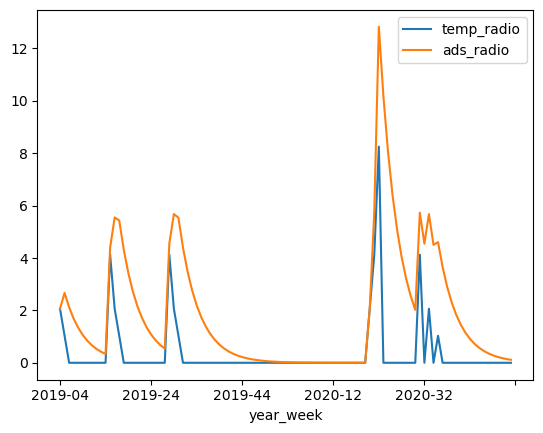

In [52]:
#validation using graph--Radio
import matplotlib.pyplot as plt
ReachDF.plot(x='year_week', y=['temp_radio', 'ads_radio'])
plt.show()

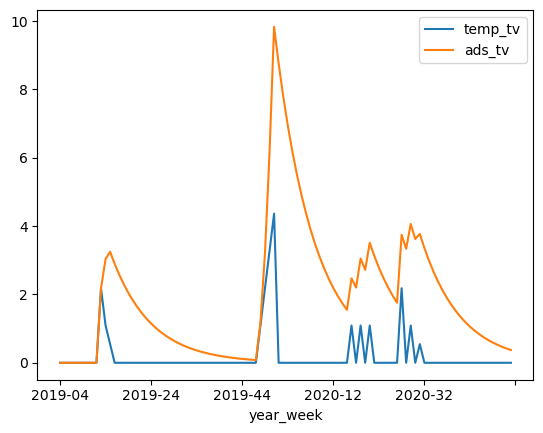

In [53]:
#validation using graph--TV
ReachDF.plot(x='year_week', y=['temp_tv', 'ads_tv'])
plt.show()

In [54]:
ReachDF.head(5)

,year_week,prod_id,sales_qty,price,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,...,Display_Cost,Facebook_Banner_Cost,Flyer_Cost,Google_Paid_Search_Cost,Radio_Cost,TV_Cost,temp_radio,temp_tv,ads_radio,ads_tv
0,2019-04,23141592,1886,3.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,...,2250.0000,1821.1250,1250.0000,1214.0000,1200.0000,0.0000,2.0630,0.0000,2.0630,0.0000
1,2019-05,23141592,777,4.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,594.8750,0.0000,940.0000,600.0000,0.0000,1.0315,0.0000,2.6689,0.0000
2,2019-06,23141592,576,4.9900,0.8830,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,628.7500,0.0000,837.0000,0.0000,0.0000,0.0000,0.0000,2.1183,0.0000
3,2019-07,23141592,530,4.9900,0.8866,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1891.2500,0.0000,444.5000,0.0000,0.0000,0.0000,0.0000,1.6813,0.0000
4,2019-08,23141592,477,4.9900,0.7818,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1571.8750,0.0000,977.0000,0.0000,0.0000,0.0000,0.0000,1.3344,0.0000


# AdStock GRP > Reach

In [55]:
import math
# define the function to calculate Reach based on Ads_stock
def calculate_reach_Radio(x):
    return 0.9 * (1 - math.exp(-0.5 * x))
# apply the function to radio 
ReachDF['reach_radio'] = ReachDF['ads_radio'].apply(calculate_reach_Radio)
ReachDF[['Radio_Amount', 'temp_radio','ads_radio','reach_radio','TV_Amount', 'temp_tv','ads_tv']].head(150)

,Radio_Amount,temp_radio,ads_radio,reach_radio,TV_Amount,temp_tv,ads_tv
0,10.0000,2.0630,2.0630,0.5792,0.0000,0.0000,0.0000
1,5.0000,1.0315,2.6689,0.6630,0.0000,0.0000,0.0000
2,0.0000,0.0000,2.1183,0.5879,0.0000,0.0000,0.0000
3,0.0000,0.0000,1.6813,0.5117,0.0000,0.0000,0.0000
4,0.0000,0.0000,1.3344,0.4382,0.0000,0.0000,0.0000
5,0.0000,0.0000,1.0592,0.3700,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.8406,0.3089,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.6672,0.2553,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.5296,0.2094,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.4203,0.1706,20.0000,2.1820,2.1820


In [56]:
#same process for TV reach
def calculate_reach_tv(a):
    return 0.95 * (1 - math.exp(-0.4 * a))

# apply the function to tv 
ReachDF['reach_tv'] = ReachDF['ads_tv'].apply(calculate_reach_tv)
ReachDF[['Radio_Amount', 'temp_radio','ads_radio','TV_Amount', 'temp_tv','ads_tv','reach_tv']].head(150)

,Radio_Amount,temp_radio,ads_radio,TV_Amount,temp_tv,ads_tv,reach_tv
0,10.0000,2.0630,2.0630,0.0000,0.0000,0.0000,0.0000
1,5.0000,1.0315,2.6689,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,2.1183,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,1.6813,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,1.3344,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,1.0592,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.8406,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.6672,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.5296,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.4203,20.0000,2.1820,2.1820,0.5531


In [57]:
# ReachDF.to_csv('NoDropFinalDF.csv', index=False)

In [58]:
#drop useless column
FinalDF=ReachDF
FinalDF = FinalDF.drop(['temp_radio', 'ads_radio', 'temp_tv', 'ads_tv'], axis=1)
FinalDF.head(5)

,year_week,prod_id,sales_qty,price,seas_index,Christmas,Easter,Halloween,Labor Day,Memorial Day,...,Radio_Amount,TV_Amount,Display_Cost,Facebook_Banner_Cost,Flyer_Cost,Google_Paid_Search_Cost,Radio_Cost,TV_Cost,reach_radio,reach_tv
0,2019-04,23141592,1886,3.9900,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000,...,10.0000,0.0000,2250.0000,1821.1250,1250.0000,1214.0000,1200.0000,0.0000,0.5792,0.0000
1,2019-05,23141592,777,4.9900,0.9275,0.0000,0.0000,0.0000,0.0000,0.0000,...,5.0000,0.0000,0.0000,594.8750,0.0000,940.0000,600.0000,0.0000,0.6630,0.0000
2,2019-06,23141592,576,4.9900,0.8830,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,628.7500,0.0000,837.0000,0.0000,0.0000,0.5879,0.0000
3,2019-07,23141592,530,4.9900,0.8866,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1891.2500,0.0000,444.5000,0.0000,0.0000,0.5117,0.0000
4,2019-08,23141592,477,4.9900,0.7818,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1571.8750,0.0000,977.0000,0.0000,0.0000,0.4382,0.0000


In [59]:
# FinalDF.to_csv('Final92DF.csv', index=False)